## Exploring housing markers in Canada and British Columbia


Average value of new mortgage loan 

Canada, provinces and CMAs 2012 Q3 to 2020 Q3

In [1]:
%run ./scr/main.py
import plotly.express as px

In [2]:
data = "./data/"

In [3]:
# Read first dataset
average_new_mortgage = pd.read_excel(data + "average-value-new-mortgage-loans-ca-prov-cmas-2012-q3-2020-q3-en.xlsx")
#average_new_mortgage.head(10)

#### Data contains quite a bit of additional information

In [4]:
# Resetting column
new_header = average_new_mortgage.iloc[3]
average_new_mortgage = average_new_mortgage[4:]
average_new_mortgage.columns = new_header

In [5]:
# Data cleanup
# Remove last 24 entries
average_new_mortgage = average_new_mortgage.iloc[:-24,1:]
# Reset index
average_new_mortgage.reset_index(inplace=True)
# Remove 'index' column 
average_new_mortgage.drop(['index'],inplace=True,axis=1)

In [6]:
average_new_mortgage.iloc[11]

3
Geography    British Columbia
2012Q3                 305427
2012Q4                 289864
2013Q1                 286652
2013Q2                 290928
2013Q3                 303663
2013Q4                 305256
2014Q1                 309374
2014Q2                 305138
2014Q3                 321625
2014Q4                 323373
2015Q1                 325035
2015Q2                 328540
2015Q3                 350672
2015Q4                 357016
2016Q1                 368782
2016Q2                 385910
2016Q3                 395297
2016Q4                 366703
2017Q1                 358655
2017Q2                 369174
2017Q3                 389430
2017Q4                 381223
2018Q1                 384794
2018Q2                 371860
2018Q3                 378187
2018Q4                 364330
2019Q1                 363239
2019Q2                 363924
2019Q3                 376343
2019Q4                 386494
2020Q1                 393711
2020Q2                 397853
2020Q3  

Cleanup of rows

In [7]:
average_new_mortgage.drop([1,12],inplace=True,axis=0)
average_new_mortgage.reset_index(inplace=True)
average_new_mortgage.drop(['index'],inplace=True,axis=1)

Data needs a fair amount of reformatting.

In [8]:
average_new_mortgage
average_new_mortgage['Region/City'] = ""
average_new_mortgage['Region/City'][average_new_mortgage.index ==0] = 'Country'
average_new_mortgage['Region/City'][(average_new_mortgage.index < 11) & (average_new_mortgage.index >0)] = 'Province'
average_new_mortgage['Region/City'][average_new_mortgage.index >= 11] = 'City'

Rearrange columns

In [9]:
# Access columns
cols = average_new_mortgage.columns.tolist()
# Bring last col to front
cols = cols[-1:] + cols[:-1]
# Set new column order
average_new_mortgage = average_new_mortgage[cols] 

Let's begin data exploration.

In [ ]:
average_new_mortgage.info()

Data types are incorrect. Let's convert to the right format.

In [10]:
# Isolate yearly and quarterly columns and convert to numeric.
int_cols = average_new_mortgage.columns.drop(['Region/City', 'Geography'])
average_new_mortgage[int_cols] = average_new_mortgage[int_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
average_new_mortgage.info()

Let's do summary statistics.

In [ ]:
average_new_mortgage.describe()

In [12]:
df_province = average_new_mortgage[average_new_mortgage['Region/City']=="Province"]

3,Region/City,Geography,2012Q3,2012Q4,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2,...,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3
1,Province,Newfoundland,188732,185794,189098,181331,191818,193100,195479,192856,...,192252,192106,188614,185276,190582,194536,193870,186268,187431,196100
2,Province,Prince Edward Island,140279,138415,137162,126763,139506,141453,141141,137427,...,182114,181967,178140,181172,181358,190715,185934,193439,189309,204415
3,Province,Nova Scotia,174688,160046,158806,159945,166426,160189,161383,157664,...,179407,190443,179921,177863,180958,193586,190168,188267,192060,207877
4,Province,New Brunswick,133390,126138,124645,122572,131542,128155,127766,124221,...,139750,150353,143324,140850,137809,152606,147047,146701,149590,160349
5,Province,Québec,159661,153413,153909,155016,160147,155512,156424,160165,...,183507,187727,173911,175658,179523,187136,183501,189390,195538,203861
6,Province,Ontario,247455,235667,233122,230770,249054,244060,244077,240828,...,315576,327367,321579,321074,324080,343117,343768,348272,363432,373371
7,Province,Manitoba,188298,181097,177560,177517,192732,189570,188107,184554,...,207436,220454,214060,206692,214873,222637,218918,212508,217416,232725
8,Province,Saskatchewan,217945,213126,206354,211979,224868,225414,226559,218781,...,229851,233255,223628,217157,216369,228721,224315,216188,225641,237386
9,Province,Alberta,282371,277555,277158,278516,289263,284928,291926,290722,...,302116,305101,295839,291721,293612,297609,297552,291747,296269,305600
10,Province,British Columbia,305427,289864,286652,290928,303663,305256,309374,305138,...,371860,378187,364330,363239,363924,376343,386494,393711,397853,417004


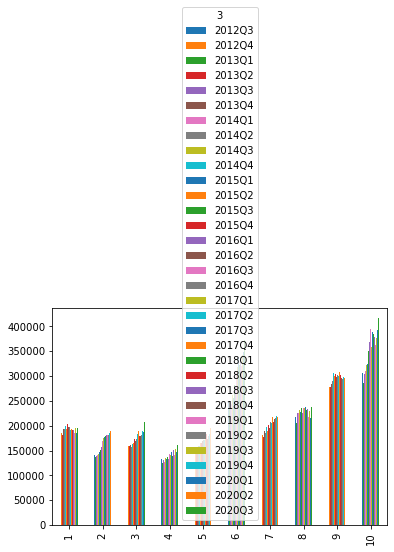

In [42]:
df_province.iloc[:,2:].plot(kind='bar')

In [61]:
plot_dict = {'box': px.box,'violin': px.violin}

In [73]:
def graph_region(df, level: str, graph_type: str):
    """
    df: data frame object with mortage data
    level: "Province" or "City"
    graph_type: "box", "violin"
    """
    
    def slice_data(df, level):
        """
        Extract a subset of df based on level
        Return a dataframe
        """
        temp = df[df['Region/City']==level]
        temp = pd.melt(temp, id_vars='Geography', value_vars=temp.columns[2:])
        temp.rename(columns = {3:'Time'}, inplace = True)
        return temp
    
    try:
        region_df = slice_data(df, level)
        fig = plot_dict[graph_type](region_df, x="Geography", y="value", color = "Geography", points='all')
        fig.update_xaxes(tickangle=-45)
        fig.show()
    
    except KeyError: print("Key not found. Make sure that 'level' is in ['Province','City']", 
                           "and 'graph_type' is in ['box','violin']")


In [74]:
graph_region(average_new_mortgage, level='city', graph_type='box')

Key not found. Make sure that 'level' is in ['Province','City'] and 'graph_type' is in ['box','violin']


In [55]:
fig = px.line(temp, x='Time', y='value', color = 'Geography')
fig.update_xaxes(tickangle=-45)
fig.show()

In [58]:
px.box(temp, x="Geography", y='value', color='Geography', points='all')

In [59]:
px.violin(temp, x="Geography", y='value', color='Geography', points='all')

## Exercise

1. Identify different ways of visualizing data. 
2. What insights do you gain for the study period? 
3. How are these insights different for each province/city?